In [2]:
import pandas as pd
import numpy as np
import csv,re,os
import datetime as dt
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import random
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
origin = '/pylon5/sy5fp1p/ehanna/logs/hosts/'

In [4]:
pattern = re.compile('(\d+-\d+-\d+)T(\d+:\d+:\d+)-(\d+:\d+)\s(.*?)\.pvt')
timePattern = re.compile('.*T(\d+:\d+:\d+)-\d+:\d+\s.*\.pvt.*')
jobidpattern = re.compile('JID:(\d+).*prolog started')

In [5]:
# date: Date for which corpus has to be made
# node: Node for which corpus has to be made
# size: Size of the sliding window. How many minutes should it study?
# slide: Shift in the sliding window
# check: Number of seconds after the current time stamp for which to check if an nfs error occured
def makeCorpus(date,node,size,slide,check):
    direc = node +'.pvt.bridges.psc.edu'
    fileName = date+'-'+direc+'.log'
    with open(origin+direc+'/'+fileName) as file:
        windowStarters = []
        CorrespondingCorpuses = []
        for line in file:
            match = re.search(timePattern,line)
            if match is not None:
                currentTime = match.group(1)
                if len(windowStarters)==0:
                    windowStarters.append(currentTime)
                    CorrespondingCorpuses.append([line,0])
                    indexCheckStart = -1
                else:
                    i = len(windowStarters)-1
                    while i>indexCheckStart:
                        checkTime = windowStarters[i]
                        FMT = '%H:%M:%S'
                        tdelta = datetime.strptime(currentTime, FMT) - datetime.strptime(checkTime, FMT)
                        sizeTimeRep = str(dt.timedelta(seconds=size))
                        errorTimeCheck = size+check
                        nextWindowStartTime = str(dt.timedelta(seconds=slide))
                        errorTimeCheckRep = str(dt.timedelta(seconds=errorTimeCheck))
                        if i==len(windowStarters)-1 and (str(tdelta)>=errorTimeCheckRep):
                            windowStarters.append(currentTime)
                            if 'not responding' not in line and 'nfs: server ' not in line:
                                CorrespondingCorpuses.append([line,0])
                            else:
                                CorrespondingCorpuses.append(['',0])
                            indexCheckStart +=1
                            break
                        elif (str(tdelta)<=sizeTimeRep):
                            if 'not responding' not in line and 'nfs: server ' not in line:
                                CorrespondingCorpuses[i][0]+= ' '+line
                                if i==len(windowStarters)-1 and (str(tdelta)>=nextWindowStartTime):
                                    windowStarters.append(currentTime)
                                    line = re.sub(r'\s\d+\s', ' ', line)
                                    if 'not responding' not in line and 'nfs: server ' not in line:
                                        CorrespondingCorpuses.append([line,0])
                                    else:
                                        CorrespondingCorpuses.append(['',0])
                        elif (str(tdelta)<=errorTimeCheckRep):
                            if 'not responding' in line and 'nfs: server ' in line:
                                CorrespondingCorpuses[i][1]=1
                        else:
                            indexCheckStart +=1
                            break
                        i=i-1
    windowStarters = [date+'_'+i+'_'+node for i in windowStarters]
    return (CorrespondingCorpuses,windowStarters)

In [6]:
def corpusToBagOfWords(corpus,labels,index):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    columns = vectorizer.get_feature_names()
    resultDF = pd.DataFrame(X.toarray(),columns=columns,index = index)
    resultDF['Label'] = labels
    return resultDF

In [11]:
def makeCorpusDataFrame(dateRange, nodeMinimum,nodeMaximum):
    startDate = datetime.strptime(dateRange.split(':')[0],"%Y-%m-%d")
    endDate = datetime.strptime(dateRange.split(':')[1],"%Y-%m-%d")
    currentDate = startDate
    corpusMetaData = []
    labelsMetaData = []
    windowStarters = []
    startTime = datetime.now()
    while (currentDate<endDate):
        count=0
        for direc in os.listdir(origin):
            if direc.startswith('r') and direc.endswith('.pvt.bridges.psc.edu'):
                match = re.search(r'(r\d+).pvt.bridges.psc.edu',direc)
                if match is not None:
                    node = match.group(1)
                    if int(node.strip('r'))> nodeMinimum and int(node.strip('r'))< nodeMaximum:
                        count+=1
                        fileName = currentDate.strftime("%Y-%m-%d")+'-'+direc+'.log'
                        if fileName in os.listdir(origin+direc+'/'):
                            with open(origin+direc+'/'+fileName) as file:
                                textCorpuseswithLabels = makeCorpus(currentDate.strftime("%Y-%m-%d"),node,300,120,60)
                                # textStrings = text.split('\n')
                                for line in textCorpuseswithLabels[0]:
                                    corpusMetaData.append(line[0])
                                    labelsMetaData.append(line[1])
                                for line in textCorpuseswithLabels[1]:
                                    windowStarters.append(line)  
        currentDate = currentDate+dt.timedelta(days=1)
    corpDF = pd.DataFrame({'Corpus':corpusMetaData,'Label':labelsMetaData})
    corpDF.to_csv("CorpusMetaData_"+currentDate.strftime("%Y-%m-%d")+".csv",index=False)
    endTime = datetime.now()
    df = corpusToBagOfWords(corpusMetaData,labelsMetaData,windowStarters)
    print(endTime-startTime)
    return df

In [8]:
# Logistic Regression
# Assumes the last column of data is the output dimension
def get_pred_logreg(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    n, m = train.shape  # number of rows and columns
    X_train = train.iloc[:,:m - 1]  # get training input data
    # print(X_train)
    Y_train = train.iloc[:,-1]
    X_test = test.iloc[:, :m - 1]  # get test input data
    Y_test = test.iloc[:,- 1]  # get test input data
    lm = LogisticRegression().fit(X_train,Y_train)
    pred = lm.predict(X_test)
    return pd.DataFrame({'Prediction':pred,'Observed':Y_test},columns=['Prediction','Observed'])


In [9]:
#your implementation of do_cv_class goes here
def do_cv_class(df, num_folds, model_name):
    Y = df.iloc[:,-1]
    kf = KFold(n_splits=num_folds,shuffle=True,random_state=2)
    predDF = pd.DataFrame(columns=['Prediction','Observed','Fold'])
    count = 1
    for train_index,test_index in kf.split(df):
        if model_name=="logreg":
            modelpredDF = get_pred_logreg(df.iloc[train_index],df.iloc[test_index])
        elif model_name=="svm":
            modelpredDF = get_pred_svm(df.iloc[train_index],df.iloc[test_index])
        elif model_name=="nb":
            modelpredDF = get_pred_nb(df.iloc[train_index],df.iloc[test_index])
        elif model_name[-2:]=="nn":
            modelpredDF = get_pred_knn(df.iloc[train_index],df.iloc[test_index],int(model_name[:-2]))
        elif model_name=="default":
            modelpredDF = get_pred_default(df.iloc[train_index],df.iloc[test_index])
        modelpredDF['Fold']=count
        count+=1
        predDF = predDF.append(modelpredDF)
    return predDF

### The code before this is just to define functions. 
The code below this will run the functions and generate dataframe which can be used to sample different number of positive and negative samples.

In [12]:
trainingDF = makeCorpusDataFrame("2018-02-04:2018-02-06",25,66)
columnsToKeep=[]
for i in trainingDF.columns:
    if any(char.isdigit() for char in i):
        continue
    else:
        columnsToKeep.append(i)
trainingDF = trainingDF.loc[:,columnsToKeep]

0:01:20.158218


After this, you just store the Indexes of positive and negative labels and randomly pick from these indexes based on number of picks required.

In [17]:
posIndexes = list(np.where(trainingDF['Label']==1)[0])
posIndexesworeplacement = posIndexes.copy()
negIndexes = list(np.where(trainingDF['Label']==0)[0])
negIndexesworeplacement = negIndexes.copy()
allSamples = len(trainingDF)
posSamples = len(posIndexes)

0.9980500000000001


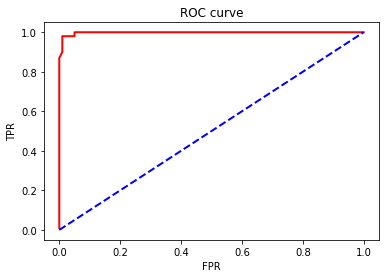

In [18]:
negSamples = 100
posSamples = 100
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
posIndexesPicked = []
while len(posIndexesPicked)<posSamples:
    if len(posIndexesworeplacement)>0:
        indexPicked = random.choice(posIndexesworeplacement)
        posIndexesPicked.append(indexPicked)
        posIndexesworeplacement.remove(indexPicked) 
    else:
            posIndexesworeplacement = posIndexes.copy()
# posIndexesPicked = posIndexes.copy()
ratioDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
lr= LogisticRegression()
inputData = ratioDF.iloc[:,:-1]
outputData = ratioDF.iloc[:,-1]
lr.fit(inputData,outputData)
preds = lr.predict_proba(inputData)[:,1]
fpr, tpr,_=roc_curve(outputData, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

0.9907142857142857


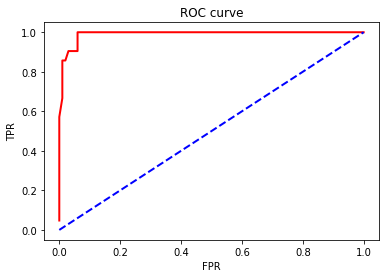

In [19]:
posIndexesRemaining = [i for i in posIndexes if i not in posIndexesPicked]
negIndexesRemaining = [i for i in negIndexes if i not in negIndexesPicked]
testDF = trainingDF.loc[trainingDF.index[posIndexesRemaining+negIndexesRemaining[:100]],:]
preds = lr.predict_proba(testDF.iloc[:,:-1])[:,1]
fpr, tpr,_=roc_curve(testDF.iloc[:,-1], preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### Case 1

In [20]:
## Train on 120 +ve and 200 -ve. Test an out of model 100-ve just to test the accuracy. Cant plot ROC curve
negSamples = 300
posSamples = 121
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
negIndexesPickedTrain = negIndexesPicked[:200]
negIndexesPickedTest = negIndexesPicked[200:]
posIndexesPicked = posIndexes.copy()
ratioDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
testDF = trainingDF.loc[trainingDF.index[negIndexesPickedTest],:]
lr= LogisticRegression()
inputData = ratioDF.iloc[:,:-1]
outputData = ratioDF.iloc[:,-1]
lr.fit(inputData,outputData)
preds = lr.predict(testDF.iloc[:,:-1])
print(1-(sum(preds)/len(preds)))

0.95


In [29]:
# corpMetaData = pd.read_csv("CorpusMetaData_2018-02-06.csv")
# corpMetaData[corpMetaData['Label']==1].to_csv("CorpusMetaDataPostiveExamples_2018-02-04.csv",index=False)
corpMetaData = pd.read_csv("CorpusMetaDataPostiveExamples_2018-02-04.csv")
# print(corpMetaData['Corpus'])

#### Feature Importance Check

In [28]:
negSamples = 300
posSamples = 121
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
negIndexesPickedTrain = negIndexesPicked[:200]
negIndexesPickedTest = negIndexesPicked[200:]
posIndexesPicked = posIndexes.copy()
ratioDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
inputData = ratioDF.iloc[:,:-1]
outputData = ratioDF.iloc[:,-1]
rf = RandomForestClassifier(n_estimators=100)
rf.fit(inputData,outputData)
finalDF = pd.DataFrame({'Feature Name':inputData.columns,'Feature Importance':rf.feature_importances_})
# print(finalDF.sort_values(by='Feature Importance',ascending=False).to_string())

### Case 2

0.9906557377049181


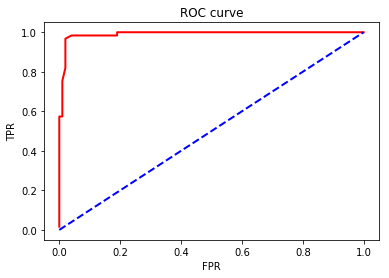

0
161
61
161


In [22]:
## Split the 120 +ve into 60 +ve and 60 +ve. Training on 60 +ve and 100 -ve. Test on the other 60+ve and other 100 -ve.  Plot ROC
negSamples = 200
posSamples = 60
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
negIndexesPickedTrain = negIndexesPicked[:100]
negIndexesPickedTest = negIndexesPicked[100:]
posIndexesPicked = []
while len(posIndexesPicked)<posSamples:
    if len(posIndexesworeplacement)>0:
        indexPicked = random.choice(posIndexesworeplacement)
        posIndexesPicked.append(indexPicked)
        posIndexesworeplacement.remove(indexPicked) 
    else:
        posIndexesworeplacement = posIndexes.copy()
posIndexesPickedTest = [i for i in posIndexes if i not in posIndexesPicked]
ratioDF = trainingDF.loc[trainingDF.index[negIndexesPickedTrain+posIndexesPicked],:]
testDF = trainingDF.loc[trainingDF.index[posIndexesPickedTest+negIndexesPickedTest],:]
lr= LogisticRegression()
inputData = ratioDF.iloc[:,:-1]
outputData = ratioDF.iloc[:,-1]
lr.fit(inputData,outputData)
preds = lr.predict(testDF.iloc[:,:-1])
outputData = testDF.iloc[:,-1]
# print(preds,outputData)
preds = lr.predict_proba(testDF.iloc[:,:-1])[:,1]
fpr, tpr,_=roc_curve(outputData, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
print(len(preds[preds==1]))
print(len(preds))
print(len(outputData[outputData==1]))
print(len(outputData))

#### Feature Importance Check

In [31]:
negSamples = 200
posSamples = 60
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
negIndexesPickedTrain = negIndexesPicked[:100]
negIndexesPickedTest = negIndexesPicked[100:]
posIndexesPicked = []
while len(posIndexesPicked)<posSamples:
    if len(posIndexesworeplacement)>0:
        indexPicked = random.choice(posIndexesworeplacement)
        posIndexesPicked.append(indexPicked)
        posIndexesworeplacement.remove(indexPicked) 
    else:
        posIndexesworeplacement = posIndexes.copy()
posIndexesPickedTest = [i for i in posIndexes if i not in posIndexesPicked]
ratioDF = trainingDF.loc[trainingDF.index[negIndexesPickedTrain+posIndexesPicked],:]
inputData = ratioDF.iloc[:,:-1]
outputData = ratioDF.iloc[:,-1]
rf = RandomForestClassifier(n_estimators=100)
rf.fit(inputData,outputData)
finalDF = pd.DataFrame({'Feature Name':inputData.columns,'Feature Importance':rf.feature_importances_})
# print(finalDF.sort_values(by='Feature Importance',ascending=False).to_string())

### Case 3

0.9125


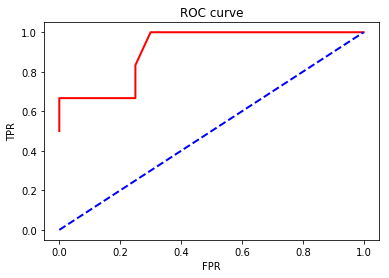

0
32
12
32


In [32]:
## Train with  120 +ve and 200 -ve. Find as many other new +ve cases as possible.  Create a balance test suite. Test on the balanced test suite.  Should be able to plot ROC
# testNewDF = makeCorpusDataFrame("2018-02-07:2018-02-08",25,66)
columnsCurrently = [i for i in testNewDF.columns if i in columnsToKeep]     
for i in columnsToKeep:
    if i not in columnsCurrently:
        testNewDF[i] = 0
testNewDF = testNewDF.loc[:,columnsToKeep]
negSamplesTrain = 200
posSamplesTrain = 120
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
posIndexesPicked = posIndexes.copy()
trainDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
negSamplesTest = 20
posSamplesTest = 12
posIndexes = list(np.where(testNewDF['Label']==1)[0])
posIndexesworeplacement = posIndexes.copy()
negIndexes = list(np.where(testNewDF['Label']==0)[0])
negIndexesworeplacement = negIndexes.copy()
negIndexesPickedTest = []
while len(negIndexesPickedTest)<negSamplesTest:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPickedTest.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
posIndexesPickedTest = []
while len(posIndexesPickedTest)<posSamplesTest:
    if len(posIndexesworeplacement)>0:
        indexPicked = random.choice(posIndexesworeplacement)
        posIndexesPickedTest.append(indexPicked)
        posIndexesworeplacement.remove(indexPicked) 
    else:
        posIndexesworeplacement = posIndexes.copy()
testDF = testNewDF.loc[testNewDF.index[posIndexesPickedTest+negIndexesPickedTest],:]
lr= LogisticRegression()
inputData = trainDF.iloc[:,:-1]
outputData = trainDF.iloc[:,-1]
lr.fit(inputData,outputData)
# preds = lr.predict(testDF.iloc[:,:-1])
outputData = testDF.iloc[:,-1]
# print(preds,outputData)
preds = lr.predict_proba(testDF.iloc[:,:-1])[:,1]
fpr, tpr,_=roc_curve(outputData, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
print(len(preds[preds==1]))
print(len(preds))
print(len(outputData[outputData==1]))
print(len(outputData))

In [43]:
corpMetaData = pd.read_csv("CorpusMetaData_2018-02-08.csv")
corpMetaData[corpMetaData['Label']==1].to_csv("CorpusMetaDataPostiveExamples_2018-02-07_25-66.csv",index=False)

#### Feature Importance Check

In [33]:
negSamplesTrain = 200
posSamplesTrain = 120
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
posIndexesPicked = posIndexes.copy()
trainDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
inputData = trainDF.iloc[:,:-1]
outputData = trainDF.iloc[:,-1]
rf = RandomForestClassifier(n_estimators=100)
rf.fit(inputData,outputData)
finalDF = pd.DataFrame({'Feature Name':inputData.columns,'Feature Importance':rf.feature_importances_})
# print(finalDF.sort_values(by='Feature Importance',ascending=False).to_string())

### Case 4

0.9063653244952166


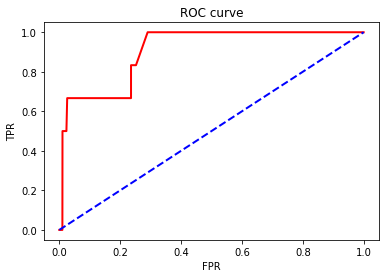

In [36]:
## Train with  100 +ve and 100 -ve. Take all cases from a newly generated dataset. Highly unbalanced case.14000 -ve cases. 6 +ve cases Should be able to plot ROC
# preds = lr.predict_proba(testNewDF.iloc[:,:-1])[:,1]
fpr, tpr,_=roc_curve(testNewDF.iloc[:,-1], preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### Case 5

In [44]:
### Make a new Dataframe
negSamplesTrain = 200
posSamplesTrain = 120
posIndexesworeplacement = posIndexes.copy()
negIndexesworeplacement = negIndexes.copy()
negIndexesPicked = []
while len(negIndexesPicked)<negSamples:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPicked.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
posIndexesPicked = posIndexes.copy()
trainDF = trainingDF.loc[trainingDF.index[posIndexesPicked+negIndexesPicked],:]
# testNewDF120 = makeCorpusDataFrame("2018-02-04:2018-02-06",1,20)
negSamplesTest = 60
posSamplesTest = 51
posIndexes = list(np.where(testNewDF['Label']==1)[0])
posIndexesworeplacement = posIndexes.copy()
negIndexes = list(np.where(testNewDF['Label']==0)[0])
negIndexesworeplacement = negIndexes.copy()
negIndexesPickedTest = []
while len(negIndexesPickedTest)<negSamplesTest:
    if len(negIndexesworeplacement)>0:
        indexPicked = random.choice(negIndexesworeplacement)
        negIndexesPickedTest.append(indexPicked)
        negIndexesworeplacement.remove(indexPicked) 
    else:
        negIndexesworeplacement = negIndexes.copy()
posIndexesPickedTest = []
while len(posIndexesPickedTest)<posSamplesTest:
    if len(posIndexesworeplacement)>0:
        indexPicked = random.choice(posIndexesworeplacement)
        posIndexesPickedTest.append(indexPicked)
        posIndexesworeplacement.remove(indexPicked) 
    else:
        posIndexesworeplacement = posIndexes.copy()
lr= LogisticRegression()
inputData = trainDF.iloc[:,:-1]
outputData = trainDF.iloc[:,-1]
lr.fit(inputData,outputData)
columnsCurrently = [i for i in testNewDF120.columns if i in columnsToKeep]     
for i in columnsToKeep:
    if i not in columnsCurrently:
        testNewDF120[i] = 0
testNewDF120 = testNewDF120.loc[:,columnsToKeep]
preds= lr.predict(testNewDF120.iloc[:,:-1])
# preds = lr.predict_proba(testNewDF120.iloc[:,:-1])[:,1]
# fpr, tpr,_=roc_curve(testNewDF120.iloc[:,-1], preds)
# roc_auc = auc(fpr, tpr)
# print(roc_auc)
# plt.figure()
# ##Adding the ROC
# plt.plot(fpr, tpr, color='red',
#  lw=2, label='ROC curve')
# ##Random FPR and TPR
# plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
# ##Title and label
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.title('ROC curve')
# plt.show()

In [67]:
corpMetaData = pd.read_csv("CorpusMetaData_2018-02-06.csv")
corpMetaData[corpMetaData['Label']==1].to_csv("CorpusMetaDataPostiveExamples_2018-02-04_1-20.csv",index=False)
# corpMetaData = pd.read_csv("CorpusMetaDataPostiveExamples_2018-02-04_1-20.csv")
# print(corpMetaData['Corpus'])

In [56]:
predLabels = np.where(preds==1)[0]

In [55]:
obsLabels = np.where(testNewDF120.iloc[:,-1]==1)[0]

In [57]:
findLabels=[]
for i in obsLabels:
    if i not in predLabels:
        findLabels.append(i)

In [69]:
toReadDF = corpMetaData.loc[obsLabels,:]

In [72]:
toReadDF.to_csv("MissedPositiveLabels.csv",index=False)

In [64]:
len(obsLabels)

51

In [71]:
corpMetaData.loc[obsLabels,:]['Label']

647      1
648      1
677      1
678      1
1327     1
1358     1
2009     1
2010     1
2042     1
2691     1
2723     1
2724     1
3373     1
3405     1
4057     1
4058     1
4089     1
4740     1
4741     1
4742     1
4772     1
4773     1
5423     1
5424     1
5454     1
6105     1
6106     1
6107     1
6137     1
6138     1
6790     1
6791     1
6821     1
6822     1
7473     1
7504     1
8189     1
8190     1
8840     1
8871     1
8872     1
9521     1
9522     1
10206    1
10207    1
10895    1
10896    1
10922    1
10923    1
11606    1
11607    1
Name: Label, dtype: int64